In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')

In [3]:
import sqlite3

# Create SQLite DB in memory
conn = sqlite3.connect(':memory:')

# Save tables
orders.to_sql('orders', conn, index=False, if_exists='replace')
payments.to_sql('payments', conn, index=False, if_exists='replace')
order_items.to_sql('order_items', conn, index=False, if_exists='replace')

# Query: Daily Revenue & Orders
query = """
SELECT 
    DATE(o.order_purchase_timestamp) AS order_date,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(p.payment_value) AS total_revenue,
    COUNT(oi.order_item_id) AS total_items
FROM 
    orders o
JOIN 
    payments p ON o.order_id = p.order_id
JOIN 
    order_items oi ON o.order_id = oi.order_id
WHERE 
    o.order_status = 'delivered'
GROUP BY 
    DATE(o.order_purchase_timestamp)
ORDER BY 
    order_date ASC;
"""

daily_sales = pd.read_sql(query, conn)
daily_sales.head()


,order_date,total_orders,total_revenue,total_items
0,2016-10-03,7,559.53,7
1,2016-10-04,54,11982.08,70
2,2016-10-05,35,13124.66,51
3,2016-10-06,41,8323.57,47
4,2016-10-07,38,8668.50,45


In [4]:
daily_sales.to_csv('daily_sales.csv', index=False)

In [5]:
# Just to make sure the date column is in the right format
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

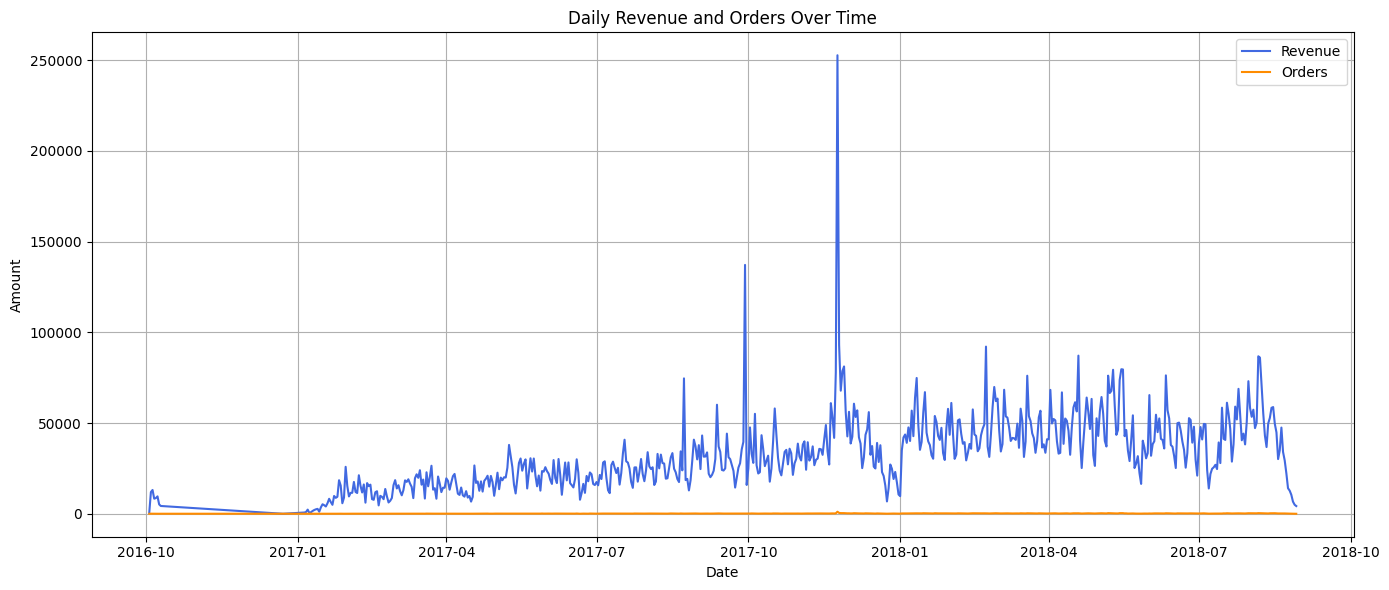

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_sales['order_date'], daily_sales['total_revenue'], label='Revenue', color='royalblue')
plt.plot(daily_sales['order_date'], daily_sales['total_orders'], label='Orders', color='darkorange')
plt.title('Daily Revenue and Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
#Exact dates with highest revenue
daily_sales.sort_values(by='total_revenue', ascending=False).head(5)

,order_date,total_orders,total_revenue,total_items
332,2017-11-24,1147,252641.82,1386
276,2017-09-29,109,137132.52,129
333,2017-11-25,487,93048.66,610
422,2018-02-22,268,92110.99,357
478,2018-04-19,287,87141.73,364


In [9]:
daily_sales['day_of_week'] = daily_sales['order_date'].dt.day_name()

In [13]:
# Group by weekday and get average revenue
weekday_avg = daily_sales.groupby('day_of_week')['total_revenue'].mean()

# Optional: Reorder for logical Mon-Sun display
weekday_avg = weekday_avg.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

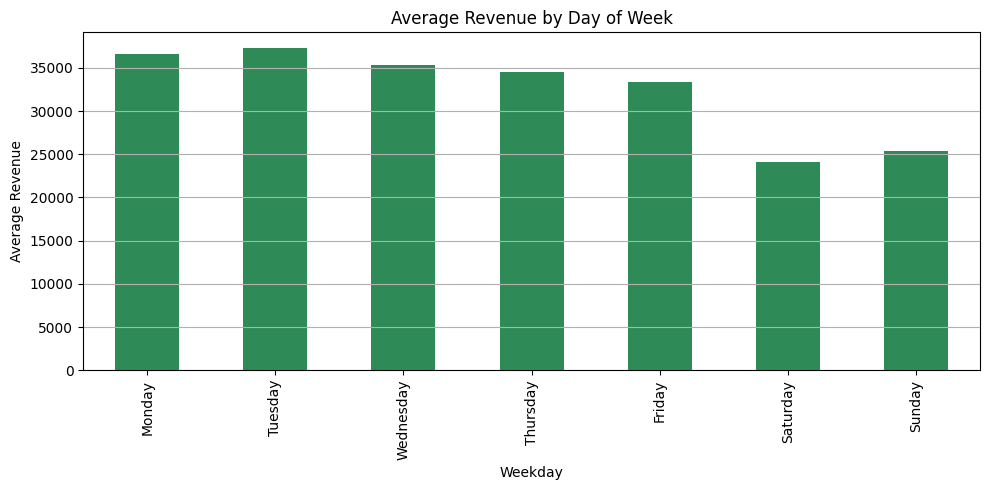

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
weekday_avg.plot(kind='bar', color='seagreen')

plt.title('Average Revenue by Day of Week')
plt.xlabel('Weekday')
plt.ylabel('Average Revenue')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:
# Create a new column with 7-day rolling average of revenue
daily_sales['revenue_7d_avg'] = daily_sales['total_revenue'].rolling(window=7).mean()
daily_sales.to_csv("daily_sales.csv",index=False)

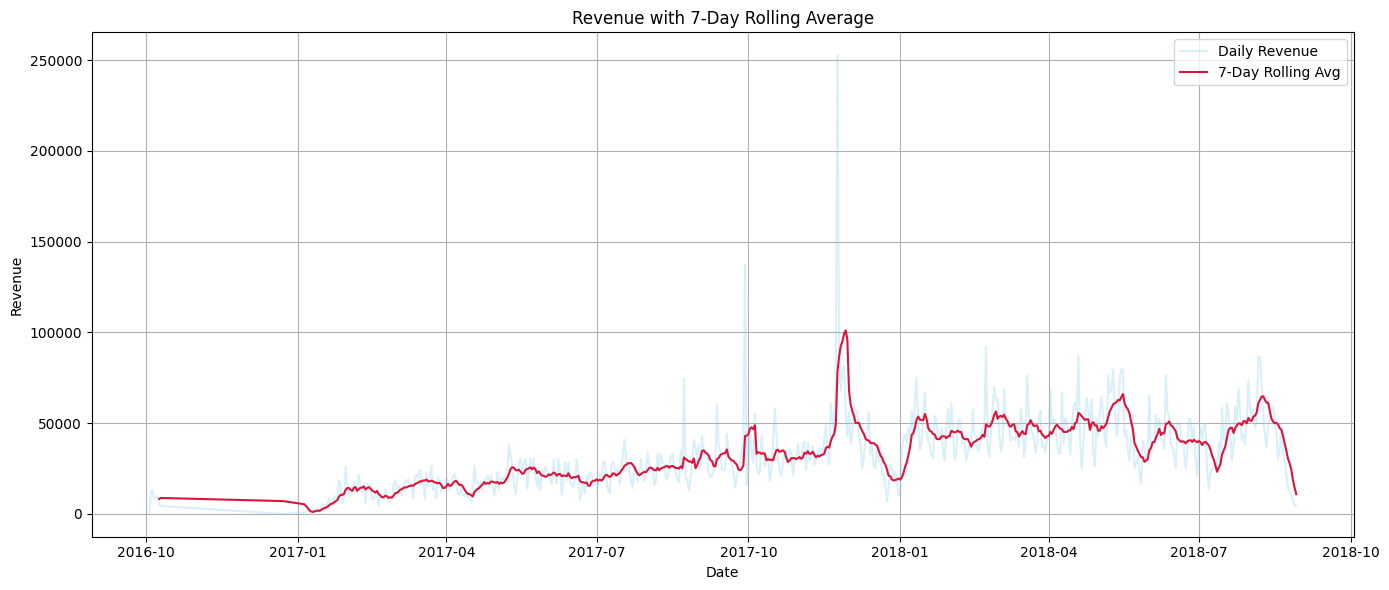

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot raw daily revenue (faded for contrast)
plt.plot(daily_sales['order_date'], daily_sales['total_revenue'], alpha=0.3, label='Daily Revenue', color='skyblue')

# Plot 7-day rolling average
plt.plot(daily_sales['order_date'], daily_sales['revenue_7d_avg'], label='7-Day Rolling Avg', color='crimson')

plt.title('Revenue with 7-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
!pip install prophet

In [16]:
from prophet import Prophet

# Rename columns for Prophet
df_prophet = daily_sales[['order_date', 'total_revenue']].rename(columns={
    'order_date': 'ds',
    'total_revenue': 'y'
})

In [17]:
# Create the Prophet model
model = Prophet()

# Fit the model to historical data
model.fit(df_prophet)

09:27:51 - cmdstanpy - INFO - Chain [1] start processing
09:27:51 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Forecast for next 30 days
future = model.make_future_dataframe(periods=30)

# Predict future revenue
forecast = model.predict(future)

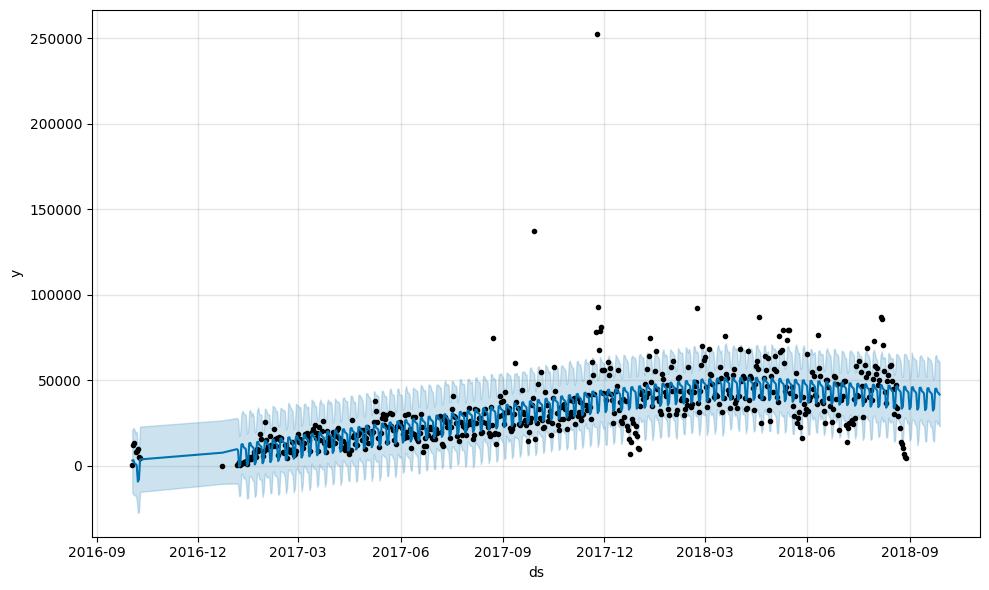

In [19]:
# Visualize the forecast with uncertainty intervals
fig = model.plot(forecast)

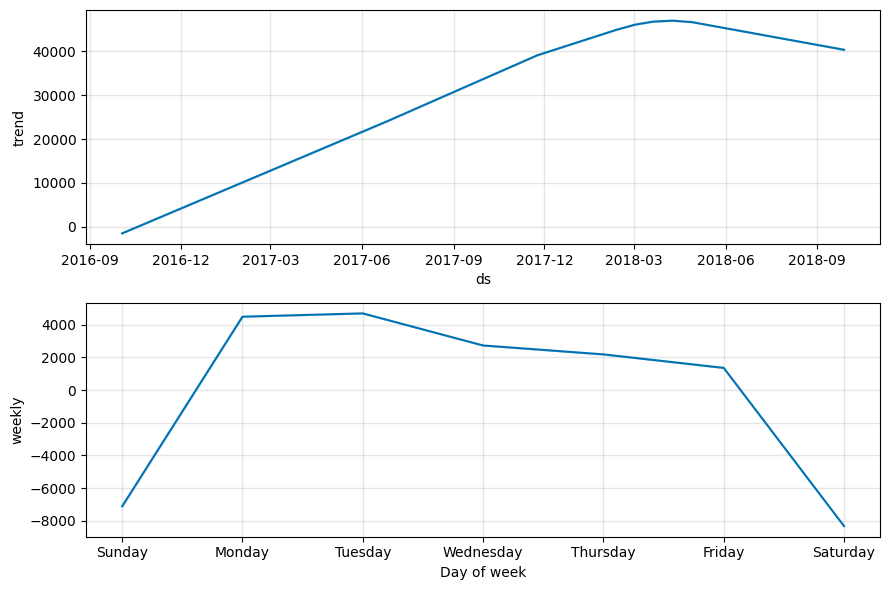

In [20]:
# Plot forecast components
fig = model.plot_components(forecast)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Prepare Prophet input format
df_prophet = daily_sales[['order_date', 'total_revenue']].rename(columns={
    'order_date': 'ds',
    'total_revenue': 'y'
})

# Step 2: Train-test split (90% train, 10% test)
split_index = int(len(df_prophet) * 0.9)
train_df = df_prophet[:split_index]
test_df = df_prophet[split_index:]

# Step 3: Train Prophet on training data
from prophet import Prophet
model_eval = Prophet()
model_eval.fit(train_df)

# Step 4: Forecast for test period
future = model_eval.make_future_dataframe(periods=len(test_df))
forecast = model_eval.predict(future)

# Step 5: Extract predicted values for test period only
predicted = forecast[['ds', 'yhat']].iloc[-len(test_df):].reset_index(drop=True)
actual = test_df.reset_index(drop=True)

# Step 6: Calculate MAE and RMSE
mae = mean_absolute_error(actual['y'], predicted['yhat'])
rmse = np.sqrt(mean_squared_error(actual['y'], predicted['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

09:28:05 - cmdstanpy - INFO - Chain [1] start processing
09:28:05 - cmdstanpy - INFO - Chain [1] done processing


MAE: 14676.78
RMSE: 19259.86


In [22]:
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')

In [23]:
products.to_sql('products', conn, index=False, if_exists='replace')

32951

In [24]:
# Define the SQL query
query = """
SELECT 
    p.product_category_name AS category,
    ROUND(SUM(oi.price), 2) AS total_revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY category
ORDER BY total_revenue DESC
LIMIT 5;
"""

# Execute the query using pandas
top_categories = pd.read_sql(query, conn)

# Display the result
top_categories

,category,total_revenue
0,beleza_saude,1258681.34
1,relogios_presentes,1205005.68
2,cama_mesa_banho,1036988.68
3,esporte_lazer,988048.97
4,informatica_acessorios,911954.32


In [25]:
query = """
SELECT 
    o.customer_id,
    ROUND(SUM(p.payment_value), 2) AS total_spent,
    COUNT(DISTINCT o.order_id) AS order_count,
    ROUND(AVG(p.payment_value), 2) AS avg_revenue_per_order
FROM orders o
JOIN payments p ON o.order_id = p.order_id
GROUP BY o.customer_id
ORDER BY total_spent DESC
LIMIT 10;
"""

top_customers = pd.read_sql(query, conn)
top_customers

,customer_id,total_spent,order_count,avg_revenue_per_order
0,1617b1357756262bfa56ab541c47bc16,13664.08,1,13664.08
1,ec5b2ba62e574342386871631fafd3fc,7274.88,1,7274.88
2,c6e2731c5b391845f6800c97401a43a9,6929.31,1,6929.31
3,f48d464a0baaea338cb25f816991ab1f,6922.21,1,6922.21
4,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,1,6726.66
5,05455dfa7cd02f13d132aa7a6a9729c6,6081.54,1,6081.54
6,df55c14d1476a9a3467f131269c2477f,4950.34,1,4950.34
7,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,1,4809.44
8,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34,1,4764.34
9,3d979689f636322c62418b6346b1c6d2,4681.78,1,4681.78


In [26]:
query = """
SELECT 
    payment_type,
    COUNT(*) AS payment_count,
    ROUND(SUM(payment_value), 2) AS total_paid,
    ROUND(AVG(payment_value), 2) AS avg_payment
FROM payments
GROUP BY payment_type
ORDER BY total_paid DESC;
"""

payment_summary = pd.read_sql(query, conn)
payment_summary

,payment_type,payment_count,total_paid,avg_payment
0,credit_card,76795,12542084.19,163.32
1,boleto,19784,2869361.27,145.03
2,voucher,5775,379436.87,65.70
3,debit_card,1529,217989.79,142.57
4,not_defined,3,0.00,0.00
